In [1]:
#import modules
import pandas as pd
from xgboost import XGBRegressor
import sklearn




#load data 
energy_data = pd.read_csv("recs2015_public_v4.csv", index_col = "DOEID")
energy_data.head()

#add new column to dataset based on US national energy prices as of July 2022.
def price_convertor(row):
    """calculates yearly energy cost in dollars"""
    current_cost = row * 0.166 #multiplies kilowatthours used between 01/01/2015-31/12/2015 by US energy prices in July 2022
    return current_cost

energy_data["2022_price"] = energy_data["KWH"].apply(price_convertor)




In [85]:
from sklearn.model_selection import train_test_split
#check if any rows are missing target data. Other columns assessed later to avoid data leakage.  
missing_target = energy_data["KWH"].isnull().sum()
print(missing_target) #no issue -> therefore no need to remove any 

#seperate target data column from dataset
y = energy_data["KWH"]


#break off predictor columns of interest
X = energy_data.loc[:,"REGIONC":"TOTSQFT_EN"] #selects all possible predictor columns 




0


In [3]:

#check if any columns contain characters
s = (X.dtypes == "object")
object_cols = list(s[s].index)
print(object_cols) 


['METROMICRO', 'UATYP10']


Found 2 columns contain characters. These columns will be one-hot encoded to convert them into a number. 

Note that dataset had already been imputed, therefore this step was skipped. 

In [6]:
#preprocessing for categorical data
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
categorical_transformer = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy = "most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(transformers = [("cat", categorical_transformer, object_cols)])


# Original Model 
Uses full set of variables to predict energy usage

In [84]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor 


#create values to alternate through to check for best parameters
N_VALUES = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
LEARNING_VALUES = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

#create dictionary to assign results to 
model_dict = {}
all_values  = []
#create function for comparing lots of models

def get_score(n_value, learning_value):

    #model = XGBRegressor(n_estimators = n_value,  learning_rate = learning_value, n_jobs = 4)

    #create pipeline 
    my_pipeline = sklearn.pipeline.Pipeline(steps =[
        ("preprocessor", preprocessor),
        ("model", RandomForestRegressor(n_estimators = n_value, random_state = 0, n_jobs = -1, criterion = "absolute_error"))
    ])

    #assess model using cross-validation
    scores = -1* cross_val_score(my_pipeline, X, y, cv = 5, scoring = "neg_mean_absolute_error")
    print(scores.mean())
    return(scores.mean())

for n_value in N_VALUES:
    for learning_value in LEARNING_VALUES: 
        score = get_score(n_value, learning_value)

        all_values.append(score)



    










5071.770917122756
5071.770917122756


KeyboardInterrupt: 

The model currently uses an infeasibly high number of features. Not only does this mean the model is impractical for any real-world applications, but it may also reduce the model's accuracy. 

c:\Users\evanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


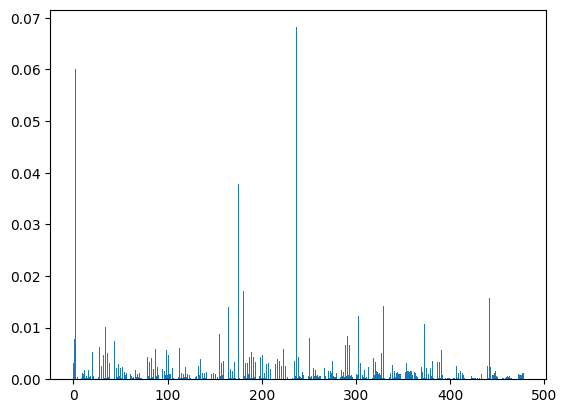

In [27]:
from matplotlib import pyplot

OH_encoder = OneHotEncoder(handle_unknown="ignore", sparse = False)
#One-hot encode dataframe (necessary because originally occured in pipeline not called here)
OH_X_cols = pd.DataFrame(OH_encoder.fit_transform(X[object_cols])) 
#readd index 
OH_X_cols.index = X.index
#remove categorical columns from X
oh_X = X.drop(object_cols, axis = 1)
#add one-hot encoded columns to main dataframe
temp_X = pd.concat([oh_X, OH_X_cols], axis = 1)

model = RandomForestRegressor(n_estimators = n_value, random_state = 0, n_jobs = -1, criterion = "absolute_error")
model.fit(temp_X, y)
importance = model.feature_importances_

#visualise importance 
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()



In [105]:
from sklearn.metrics import mean_absolute_error
importance_dict = {}

for i, v in enumerate(importance):
    importance_dict[i] = v



#get top 30 most important features 
sort = sorted(importance_dict, key=importance_dict.get, reverse=True)
top_30 = [str(X.columns[i]) for i in sort[10:30]]



#get column name for each index position 


X_copy = X.copy()

X_top_30 = X_copy.loc[:,top_30]
print(X_top_30)


c:\Users\evanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


1166.243570753603
       TOPFRONT  SOLOTHER  SWAMPCOL  USENOTMOIST  HHSEX  SWIMPOOL  OTHROOMS  \
DOEID                                                                         
10001         2         0         0           -2      2         0         4   
10002        -2         0         0           -2      1         0         2   
10003         2         0         0           -2      1         0         5   
10004         1         0        -2           -2      1         0         4   
10005         1         0        -2            1      2         0         3   
...         ...       ...       ...          ...    ...       ...       ...   
15682        -2         0        -2           -2      1        -2         2   
15683         1         0         0           -2      1         0         2   
15684        -2         0        -2           -2      1        -2         2   
15685         1         0         0           -2      1         0         2   
15686        -2         0        -

# Top 30 model 
Uses only the 30 most important features to reduce processing time. Comes at relatively small decrease in model accuracy. 



In [98]:
#pre-processing
#check if any columns contain characters
s = (X_top_30.dtypes == "object")
object_cols_T30 = list(s[s].index)
print(object_cols_T30) 

preprocessor_T30 = ColumnTransformer(transformers = [("cat", categorical_transformer, object_cols_T30)])


[]


In [99]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor 


#create values to alternate through to check for best parameters
N_VALUES = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
LEARNING_VALUES = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

#create dictionary to assign results to 
model_dict_T30 = {}
all_values_T30  = []

def get_score_M2(n_value, learning_value):

    #model = XGBRegressor(n_estimators = n_value,  learning_rate = learning_value, n_jobs = 4)

    #create pipeline 
    my_pipeline = sklearn.pipeline.Pipeline(steps =[
        ("preprocessor", preprocessor_T30),
        ("model", RandomForestRegressor(n_estimators = n_value, random_state = 0, n_jobs = -1, criterion = "absolute_error"))
    ])

    #assess model using cross-validation
    scores = -1* cross_val_score(my_pipeline, X, y, cv = 5, scoring = "neg_mean_absolute_error")
    print(scores.mean())
    return(scores.mean())

for n_value in N_VALUES:
    for learning_value in LEARNING_VALUES: 
        score = get_score_M2(n_value, learning_value)

        all_values_T30.append(score)





ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\evanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\evanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\evanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py", line 331, in fit
    X, y = self._validate_data(
  File "c:\Users\evanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 596, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\evanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py", line 1074, in check_X_y
    X = check_array(
  File "c:\Users\evanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py", line 918, in check_array
    raise ValueError(
ValueError: Found array with 0 feature(s) (shape=(4548, 0)) while a minimum of 1 is required by RandomForestRegressor.

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\evanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\evanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\evanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py", line 331, in fit
    X, y = self._validate_data(
  File "c:\Users\evanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 596, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\evanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py", line 1074, in check_X_y
    X = check_array(
  File "c:\Users\evanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py", line 918, in check_array
    raise ValueError(
ValueError: Found array with 0 feature(s) (shape=(4549, 0)) while a minimum of 1 is required by RandomForestRegressor.


c:\Users\evanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.118030151663075
